In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
sys.path.append('/home/mi/robertsk/sideproject/py27/lib/python2.7/site-packages')
sys.path.append('/home/mi/robertsk/sideproject/py27/local/lib/python2.7/site-packages')

In [6]:
import numba
from numba import jit

In [12]:
img = mpimg.imread('test.png') 

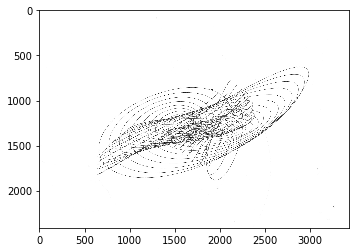

In [13]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

gray = rgb2gray(img).T    

plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

In [14]:
np.shape(gray)

(2412, 3437)

In [15]:
2412*3437

8290044

In [16]:
183952

183952

In [17]:
threshold=0.5

In [18]:
gray=gray.T
bimg=np.copy(gray)
bimg[gray<threshold]=1
bimg[gray>=threshold]=0

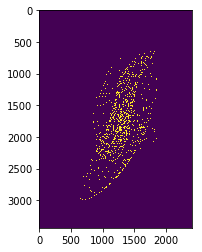

In [19]:
plt.imshow(bimg)

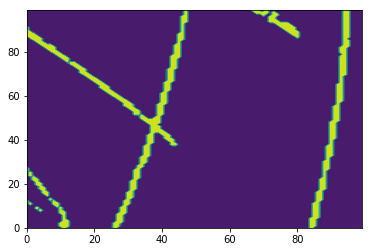

In [20]:
plt.contourf(bimg[1500:1600,1500:1600])

In [183]:
def quadratic_hierachy(bimg,level=5):
    bimg0=np.zeros(np.array(bimg.shape)+2*level)
    bimg0[level:-level,level:-level]=bimg
    points0=np.array(np.where(bimg0==1))
    points=np.copy(points0)
    spirals0=np.zeros([3,len(points0[0,:])])
    hierachy=[]
    pointlabel=np.arange(len(points[0,:]))
    result=[pointlabel]
    a=bimg0.shape[0]
    spiralmem=[points0[0,:]*a+points0[1,:]]
    for i in range(level):
        steps=3+2*i
        spirals=np.zeros([steps,len(points[0,:])])
        spiralmems=np.zeros([steps,len(points[0,:])],dtype=np.int64)
        for j in range(steps):
            if i%2==0:
                if j==0:
                    points[0,:]=points[0,:]-1
                    spirals[j]=bimg0[points[0,:],points[1,:]]
                    spiralmems[j]=points[0,:]*a+points[1,:]
                elif j<(i+2):
                    points[1,:]=points[1,:]-1
                    spirals[j]=bimg0[points[0,:],points[1,:]]
                    spiralmems[j]=points[0,:]*a+points[1,:]
                else:
                    points[0,:]=points[0,:]+1
                    spirals[j]=bimg0[points[0,:],points[1,:]]
                    spiralmems[j]=points[0,:]*a+points[1,:]
            else:
                if j==0:
                    points[0,:]=points[0,:]+1
                    spirals[j]=bimg0[points[0,:],points[1,:]]
                    spiralmems[j]=points[0,:]*a+points[1,:]
                elif j<(i+2):
                    points[1,:]=points[1,:]+1
                    spirals[j]=bimg0[points[0,:],points[1,:]]
                    spiralmems[j]=points[0,:]*a+points[1,:]
                else:
                    points[0,:]=points[0,:]-1
                    spirals[j]=bimg0[points[0,:],points[1,:]]
                    spiralmems[j]=points[0,:]*a+points[1,:]
                    
        check=np.sum(spirals,axis=0)==steps
        points=points[:,check]
        pointlabel=pointlabel[check]
        print(np.sum(check))
        spiralmem.append(spiralmems[:,check])
        result.append(pointlabel)
        hierachy.append(np.setdiff1d(result[i],result[i+1]))
    hierachy.append(result[-1])
    
    fullspiral=[]
    for j in range(len(spiralmem[0])):
            fullspiral.append([spiralmem[0][j]])
    for i in range(1,level): 
        for j in range(len(spiralmem[i][0,:])):
            if len(result[i])==0:
                pass
            else:
                fullspiral[result[i][j]].extend(spiralmem[i][:,j].tolist())
    sh=[]
    nh=[]
    retspiral=[]
    for i in range(len(hierachy)):
        sh.append([fullspiral[j] for j in hierachy[i]])
        nh.append([])
        retspiral.append([])
    for i in range(level):
        search=[]

        for j in range(i,level):
            search.extend(sh[j+1]) 
        sear=set(np.unique([item for sublist in search for item in sublist]))
        for j in range(len(hierachy[i])):
            if len(set(fullspiral[hierachy[i][j]])-sear)!=0:
                nh[i].append(points0[:,hierachy[i][j]].tolist())
                retspiral[i].append(fullspiral[hierachy[i][j]])
    for i in range(len(nh)):
        if i%2==0:
            nh[i]=np.array(nh[i])-level
        else:
            nh[i]=np.array(nh[i])-level-0.5

    newsp=[]
    for i in range(len(retspiral)):
        newsp.append([])
        temp=np.zeros([2,(i+1)**2])
        for j in range(len(retspiral[i])):
            temp[0,:]=np.array(np.array(retspiral[i][j])/a,dtype=np.int64)
            temp[1,:]=np.array(retspiral[i][j])-temp[0,:]*a
            temp=temp-level
            newsp[i].append(temp.astype(np.int64))
            
    return nh,newsp

In [184]:
nh,newsp=quadratic_hierachy(bimg,level=9)

81606
20607
7511
2714
946
284
73
9
0


In [185]:
def helper(ones,running,nhi,nci,i,shape):
    nonzero=np.zeros(4*(i+1),dtype=bool)
    for j in range(len(nhi)):
            xx=running+int(nhi[j][0]-0.5*i)
            x0=ones*int(nhi[j][0]-0.5*i-1)
            x1=ones*int(nhi[j][0]+0.5*i+1)
            yy=running+int(nhi[j][1]-0.5*i)
            y0=ones*int(nhi[j][1]-0.5*i-1)
            y1=ones*int(nhi[j][1]+0.5*i+1)
            x=np.concatenate((xx,x0,x1))#.astype(int)
            y=np.concatenate((y0,y1,yy))#.astype(int)
            positiv=(x>=0)*(y>=0)*(x<shape[0])*(y<shape[1])
            nonzero[positiv]=bimg[x[positiv],y[positiv]]==1
            c=x*shape[0]+y
            nci[j][nonzero]=c[nonzero]
    return nci


def neighbours(nh,bimg):
    a=bimg.shape[0]
    nc=[]
    for i in range(len(nh)):
        ones=np.ones(i+1,dtype=int)
        running=np.arange(2*(i+1),dtype=int)%(i+1)
        #running=np.arange(i+1,dtype=int)
        nci=np.zeros([len(nh[i]),4*(i+1)],dtype=int)-1
        nci2=helper(ones,running,nh[i],nci,i,bimg.shape)
        ncil=nci2.tolist()
        nc.append(list(filter(lambda a: a != -1, subl) for subl in ncil ))
    return nc

In [186]:
def neighbours(nh,bimg):
    a=bimg.shape[0]
    nc=[]
    for i in range(len(nh)):
        nc.append([])
        ones=np.ones(i+1,dtype=int)
        running=np.arange(2*(i+1),dtype=int)%(i+1)
        for j in range(len(nh[i])):
            nc[i].append([])
            xx=running+int(nh[i][j][0]-0.5*i)
            x0=ones*int(nh[i][j][0]-0.5*i-1)
            x1=ones*int(nh[i][j][0]+0.5*i+1)
            yy=running+int(nh[i][j][1]-0.5*i)
            y0=ones*int(nh[i][j][1]-0.5*i-1)
            y1=ones*int(nh[i][j][1]+0.5*i+1)
            x=np.concatenate((xx,x0,x1))
            y=np.concatenate((y0,y1,yy))
            positiv=(x>=0)*(y>=0)*(x<bimg.shape[0])*(y<bimg.shape[1])
            x=x[positiv]
            y=y[positiv]
            nonzero=bimg[x,y]==1
            c=x*a+y
            nc[i][j].append(c[nonzero])
            nc[i][j]=nc[i][j][0]
    return nc

In [187]:
nc=neighbours(nh,bimg)

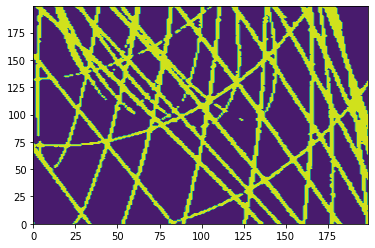

In [202]:
example=bimg[1300:1500,1300:1500]
plt.contourf(example)
#bimg=example

In [145]:
nh,newsp=quadratic_hierachy(example,level=8)

4024
1169
420
139
43
9
3
0


In [146]:
nc=neighbours(nh,example)

In [310]:
len(nc)

10

In [207]:
def func(bimg,newsp,nh,nc):
    #flatten all hierachies
    a=bimg.shape[0]
    #flatnh=[]
    flatnhc=[]
    newspc=[]
    for i in range(len(newsp)):
        newspc.append([])
        for j in range(len(newsp[i])):
            newspc[i].append([])
            #flatnh.append(nh[i][j])
            newspc[i][j].append(newsp[i][j][0]*a+newsp[i][j][1])
            newspc[i][j]=newspc[i][j][0]

            flatnhc.append(nh[i][j][0]*a+nh[i][j][1])
    flatunc=np.unique([ii for subsubl 
                    in [i for subl in nc for i in subl] 
                    for ii in subsubl])

    for i in range(len(newspc)):
        newspc[i]=np.array(newspc[i],dtype=int)

    ups={}
    for i in range(len(flatunc)):
        ups[flatunc[i]]=[]
        for j in range(len(newspc)):
            if flatunc[i] in newspc[j]:
                #print('sdf')
                #print(i,j,np.where(newspc[j]==flatunc[i]))
                
                ups[flatunc[i]].append((j,np.where(newspc[j]==flatunc[i])[0]))
    return ups,flatnhc

In [208]:
ups,flatnhc=func(bimg,newsp,nh,nc)

In [241]:
from scipy.sparse import lil_matrix
from scipy.sparse import find
S = lil_matrix((len(flatnhc), len(flatnhc)), dtype=int)

nhl=[]
for i in range(len(nh)):
    nhl.append(len(nh[i]))

a=bimg.shape[0]
neworder=np.zeros([2,len(flatnhc)],dtype=int)
counter=0
for i in range(len(nc)):
    for j in range(len(nc[i])):
        for k in range(len(nc[i][j])):
            for l in range(len(ups[nc[i][j][k]])):
                hier=ups[nc[i][j][k]][l][0]
                nei=np.sum(nhl[:hier])+ ups[nc[i][j][k]][l][1]
                for m in range(len(nei)):
                    S[np.sum(nhl[:i])+j,nei[m]]=1
            #ups[nc[i][j][k]]
        neworder[0,counter]=np.sum(nhl[:i])+j
        neworder[1,counter]=nh[i][j][0]*a+nh[i][j][1]
        counter+=1
    

In [267]:
neighbourlist=[]
for i in range(len(flatnhc)):
    neighbourlist.append(find(S[i,:])[1])
    

In [302]:
nei2=[]
#neighbourlist
for i in range(len(neighbourlist)):
    nei2.append([])
    for j in neighbourlist[i]:
        nei2[i].extend(neighbourlist[j])
        nei2[i].remove(i)
    nei2[i]=np.unique(nei2[i])

In [304]:
nei3=[]
for i in range(len(neighbourlist)):
    nei3.append([])
    for j in nei2[i]:
        nei3[i].extend(neighbourlist[j])

In [308]:
triangles=[i in nei3[i] for i in range(len(nei3))]

In [309]:
np.sum(triangles)

45045

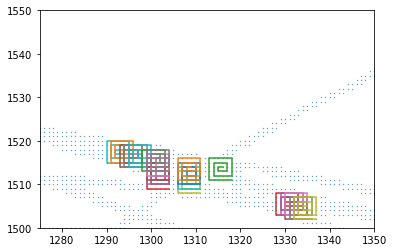

In [21]:
lev=5
retspiral=newsp
for i in range(len(retspiral[lev])):
    plt.plot(retspiral[lev][i][0],retspiral[lev][i][1])
plt.xlim([1275,1350])
plt.ylim([1500,1550])
plt.scatter(x,y,s=0.1)


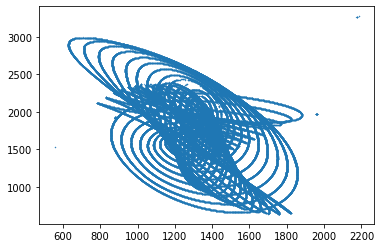

In [177]:
plt.scatter(x,y,s=0.1)

In [154]:
newsp[2][0][0,:]

array([801, 800, 800, 801, 802, 802, 802, 801, 800])

In [163]:
newsp[2][0][1,:]

array([2104, 2104, 2103, 2103, 2103, 2104, 2105, 2105, 2105])

In [175]:
bimg[newsp[3][0][0],newsp[3][0][1]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

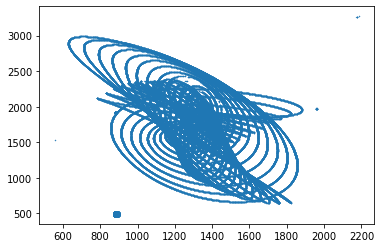

In [176]:
plt.plot(newsp[3][0][0,:],newsp[3][0][1,:],'o')
threshold=0.5
x=np.where(gray<threshold)[0]
y=np.where(gray<threshold)[1]
plt.scatter(x,y,s=0.1)

#plt.xlim([790,810])
#plt.ylim([2050,2150])
#plt.xlim([1860,1865])
#plt.ylim([1208,1212])

In [ ]:
threshold=0.5
x=np.where(gray<threshold)[0]
y=np.where(gray<threshold)[1]
plt.scatter(x,y,s=0.1)
#plt.xlim([1400,1500])
#plt.ylim([1500,1550])
for i in range(8):
    plt.plot(nh[i][:,0],nh[i][:,1],'s',markersize=i*5+3)

plt.scatter(x,y,s=0.1)
plt.xlim([1420,1460])
plt.ylim([1510,1550])

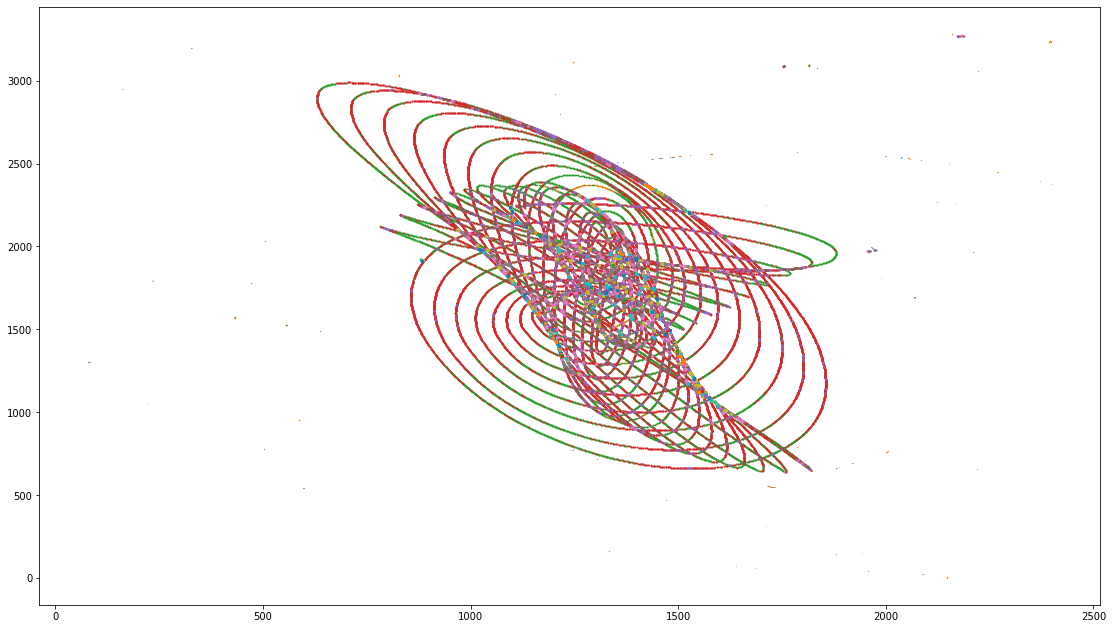

In [395]:
plt.figure(figsize=[19,11])
for i in range(15):
    plt.plot(nh[i][:,0],nh[i][:,1],'s',markersize=i*0.2+0.1)
plt.savefig('linewidth_color2.png',format='png',dpi=400)

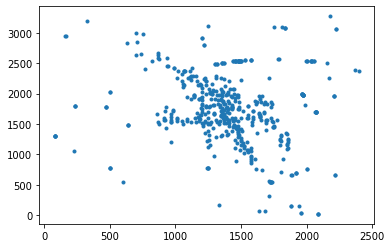

In [13]:
plt.plot(nh[0][:,0],nh[0][:,1],'.')

(1510, 1550)

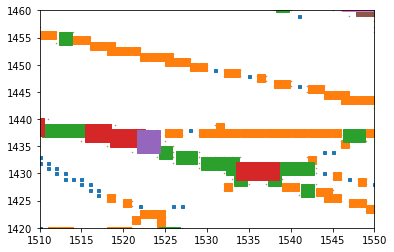

In [22]:
threshold=0.5
x=np.where(gray<threshold)[0]
y=np.where(gray<threshold)[1]
plt.scatter(x,y,s=0.1)
#plt.xlim([1400,1500])
#plt.ylim([1500,1550])
for i in range(8):
    plt.plot(nh[i][:,0],nh[i][:,1],'s',markersize=i*5+3)

plt.scatter(x,y,s=0.1)
plt.ylim([1420,1460])
plt.xlim([1510,1550])

(1510, 1550)

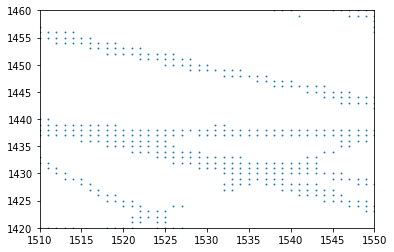

In [14]:
plt.scatter(x,y,s=0.8)
plt.ylim([1420,1460])
plt.xlim([1510,1550])

In [21]:
len(nh)

9